# This notebook is used to generate TFRecords files

In [4]:
import os
import glob

import skimage
import numpy as np
import random

import matplotlib
import matplotlib.pyplot as plt

from shutil import copyfile

from shutil import copytree
from shutil import rmtree

from supreshelper import *

from typing import List
from typing import Tuple

In [5]:
data_path = "Data/"
data_destination = "DataNormalized"

train = glob(data_path +  "train/*/*") 
test = glob(data_path + "test/*/*") 

In [6]:
print(len(train), len(test))

1160 290


# Count max number of LRs

In [7]:
max_lrs = 0
for scene in glob(data_path + "train/*/*") + glob(data_path + "test/*/*"):
    lrs = len(glob(scene + "/LR*"))
    if max_lrs < lrs:
        max_lrs = lrs
        print(scene)

print(max_lrs)

Data/train/RED/imgset0486
Data/train/RED/imgset0291
Data/train/RED/imgset0429
Data/train/RED/imgset0319
35


# Compute HR mean, std and LR mean and std

In [8]:
def one_channel_mean_std(images: List[str], image_size: Tuple[int, int]):
    """ Compute mean and std for 1 channel images
    
        Args:
            scenes: list of strings to path of each scene
            image_size: dimension of the images
            
        Return:
            the mean and std of all the images
    
    """
    cum = np.zeros(image_size) 
    for image in images:
        cum += skimage.img_as_float64(skimage.io.imread(image) << 2)
    cum = cum / len(images)
    
    return np.mean(cum), np.std(cum)

In [9]:
red_hr = glob(data_path + "train/RED/*/HR.png")
nir_hr = glob(data_path + "train/NIR/*/HR.png")

red_hr_mean, red_hr_std = one_channel_mean_std(red_hr, [384,384])
nir_hr_mean, nir_hr_std = one_channel_mean_std(nir_hr, [384,384])

print("train HR means: (NIR/RED)",  nir_hr_mean, red_hr_mean)
print("train HR stds: (NIR/RED)", nir_hr_std, red_hr_std)

train HR means: (NIR/RED) 0.46655891560934365 0.30600543891250215
train HR stds: (NIR/RED) 0.003788212186307545 0.003027200860056296


In [10]:
red_lrs = glob(data_path + "test/RED/*/LR*.png")
nir_lrs = glob(data_path + "test/NIR/*/LR*.png")

red_lr_mean, red_lr_std = one_channel_mean_std(red_lrs, [128,128])
nir_lr_mean, nir_lr_std = one_channel_mean_std(nir_lrs, [128,128])

print("test LR means: (NIR/RED)", nir_lr_mean, red_lr_mean)
print("test LR stds: (NIR/RED)", nir_lr_std, red_lr_std)

test LR means: (NIR/RED) 0.4965061760039976 0.3305909456284393
test LR stds: (NIR/RED) 0.005581005436479948 0.0062824011793455046


In [11]:
red_lrs = glob(data_path + "train/RED/*/LR*.png")
nir_lrs = glob(data_path + "train/NIR/*/LR*.png")

red_lr_mean, red_lr_std = one_channel_mean_std(red_lrs, [128,128])
nir_lr_mean, nir_lr_std = one_channel_mean_std(nir_lrs, [128,128])

print("train LR means: (NIR/RED)", nir_lr_mean, red_lr_mean)
print("train LR stds: (NIR/RED)", nir_lr_std, red_lr_std)

train LR means: (NIR/RED) 0.4768749148141379 0.3202051185712178
train LR stds: (NIR/RED) 0.003244550852000419 0.0039556822390636945


# Standardizing differently for NIR and RED could be a good idea, but in practice normalizing was better because of small s.t.d

In [9]:
def inplace_standardize(image, mean, std):
    image -= mean
    image /= std

# Normalization

In [43]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

In [50]:
def load_and_normalize_hr(scene_path):
    hr, _ = highres_image(scene_path, img_as_float=False)
    hr = skimage.img_as_float64(hr << 2)
    return normalize(hr)

In [51]:
def load_and_normalize_lrs(scene_path):
    
    normalized_lrs = []
    for lr, _ in lowres_image_iterator(scene_path, img_as_float=False):
        lr = skimage.img_as_float64(lr << 2)
        normalized_lrs.append(normalize(lr))
    
    return normalized_lrs

0.0 1.0


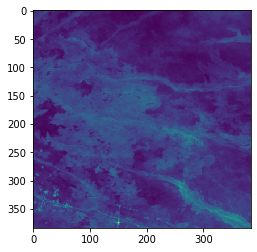

In [57]:
# HR test
test_hr = load_and_normalize_hr(train[0])
plt.imshow(test_hr)
print(test_hr.min(), test_hr.max())

0.0 1.0


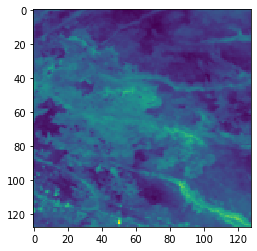

In [60]:
# LR test
test_lrs = load_and_normalize_lrs(train[0])
plt.imshow(test_lrs[9])
print(test_lrs[3].min(), test_lrs[7].max())

# Central Tendency and upscaling + competition baseline

In [64]:
def mergeAndUpscale(scene_path):
    merged = central_tendency(scene_path, agg_with='median', only_clear=False)
    return bicubic_upscaling(merged)

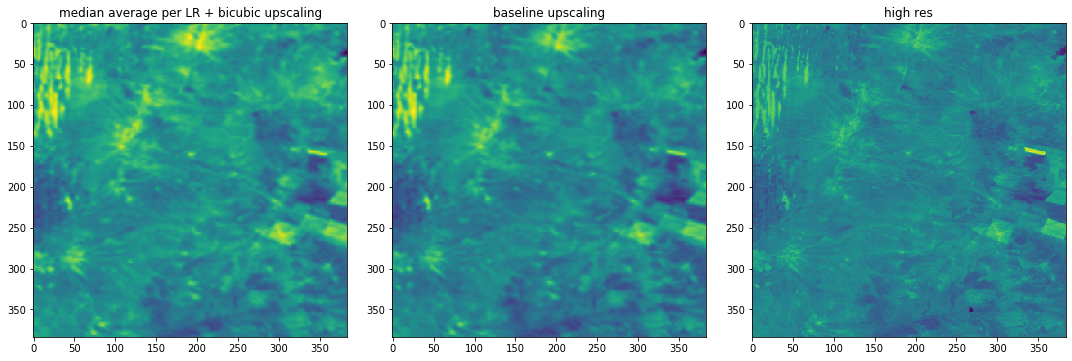

In [63]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,3,1)
plt.imshow(mergeAndUpscale(train[1]))
plt.title("median average per LR + bicubic upscaling")
ax = fig.add_subplot(1,3,2)
plt.imshow(baseline_upscale(train[1]))
plt.title("baseline upscaling")
ax = fig.add_subplot(1,3,3)
plt.title("high res")
plt.imshow(highres_image(train[1])[0])

plt.tight_layout()

In [81]:
def array_to_tfrecords_single(all_, output_file):
    feature ={ "all": tf.train.Feature(float_list=tf.train.FloatList(value=all_.flatten()))}
    
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    serialized = example.SerializeToString()

    writer = tf.io.TFRecordWriter(output_file)
    writer.write(serialized)
    writer.close()

In [82]:
def array_to_tfrecords_multiple(lrs, hr, output_file):
    feature ={"lrs": tf.train.Feature(float_list=tf.train.FloatList(value=np.concatenate(lrs).ravel())),
              # We don't need the list length after deciding to use a fixed length now
              #"lrs_length": tf.train.Feature(int64_list=tf.train.Int64List(value=[len(lrs)])),
              "hr": tf.train.Feature(float_list=tf.train.FloatList(value=hr.flatten())),
             }
    
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    serialized = example.SerializeToString()

    writer = tf.io.TFRecordWriter(output_file)
    writer.write(serialized)
    writer.close()

In [88]:
def save_scene(scene_path):
    new_path = data_destination + "/" + "/".join(scene_path.split("/")[1:])
    os.makedirs(new_path, exist_ok=True)
    
    lr_filler = central_tendency(scene_path, agg_with='median', only_clear=False)
    lr_filler = normalize(lr_filler)
    
    lrs = load_and_normalize_lrs(scene_path)

    # Fill the list with the "filler" LR to get 35 filters
    for i in range(0, max_lrs - len(lrs)):
        lrs.append(lr_filler)
    
    # Shuffle the list randomly
    random.shuffle(lrs)
    
    sm = skimage.img_as_float64(skimage.io.imread(scene_path + "/" + 'SM.png'))
    
    if scene_path.split("/")[1] == "train":
        hr = load_and_normalize_hr(scene_path)
        hr = np.where(sm > 0, hr, np.NaN)
        array_to_tfrecords_multiple(lrs, hr, new_path + "/" + "multiple.tfrecords")
        
    else:
        array_to_tfrecords_multiple(lrs, np.ones([384,384]), new_path + "/" + "multiple.tfrecords")
    
    for f in glob(scene_path+ "/*"):
        copyfile(f,  data_destination + "/" + "/".join(f.split("/")[1:]))

In [89]:
for scene in train + test:
    save_scene(scene)

### OPTIONAL: Move 30 random scenes to the dev directory for validation

In [3]:
for scene in random.sample(glob(data_destination +  "/train/*/*"), 30):
    scene_elem = scene.split("/")
    dst = data_destination + "/dev/" + "/".join(scene_elem[2:])
    copytree(scene, dst)
    rmtree(scene)

### Backup old
save_scene for standardization

In [40]:
def save_scene(scene_path, hr_mean, hr_std, lr_mean, lr_std):
    new_path = data_destination + "/" + "/".join(scene_path.split("/")[1:])
    os.makedirs(new_path, exist_ok=True)
    
    lr_filler = central_tendency(scene_path, agg_with='median', only_clear=False)
    inplace_standardize(lr_filler, lr_mean, lr_std)
    
    lrs = []
    for lr, _ in lowres_image_iterator(scene_path):
        inplace_standardize(lr, lr_mean, lr_std)
        lrs.append(lr)
        
    # Fill the list with the median of all LR to reach the max amount
    for i in range(0, max_lrs - len(lrs)):
        lrs.append(lr_filler)
    
    # Shuffle the list randomly
    random.shuffle(lrs)
    
    SM = skimage.img_as_float64(skimage.io.imread(scene_path + "/" + 'SM.png'))
    
    if scene_path.split("/")[1] == "train":
        HR = skimage.img_as_float64(skimage.io.imread(scene_path + "/" + 'HR.png'))
        inplace_standardize(HR, hr_mean, hr_std)
        array_to_tfrecords_multiple(lrs, np.where(SM > 0, HR, np.NaN), new_path + "/" + "multiple.tfrecords")
        
    else:
        array_to_tfrecords_multiple(lrs, np.ones([384,384]), new_path + "/" + "multiple.tfrecords")
    
    for f in glob(scene_path+ "/*"):
        copyfile(f,  data_destination + "/" + "/".join(f.split("/")[1:]))